In [111]:
# Import section libraries

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import statsmodels.api as sm

from matplotlib.pyplot import rcParams
from scipy import stats
from sklearn.linear_model import LinearRegression

In [17]:
# Some settings

# Size of plottings

rcParams['figure.figsize'] = 25,6


### Sensitive parameters ###

# Copy them from env file.

In [18]:
# Connection settings

connection = psycopg2.connect(user=eleph_db_user,
                                    password=eleph_db_password,
                                    host=eleph_db_host,
                                    port=eleph_db_port,
                                    database=eleph_db_name)

In [19]:
ux_product_name= 'Maize'
ux_market_id = 'Kampala : UGA'
ux_source_id = '1'
ux_currency_code = 'UGX'
ux_mode_price = 'wholesale_observed_price'

In [20]:
query = '''
    SELECT date_price, unit_scale, wholesale_observed_price
                    FROM maize_raw_info
                     WHERE product_name = 'Maize'
                    AND market_id = 'Kampala : UGA'
                    AND source_id = '1'
                    AND currency_code = 'UGX'
                    AND date_price > '2015-12-31'
'''

kampala_ws = pd.read_sql(query, con=connection)

connection.close()

In [21]:

print(kampala_ws.dtypes)
print('Shape: ',kampala_ws.shape)
kampala_ws.head()

date_price                   object
unit_scale                   object
wholesale_observed_price    float64
dtype: object
Shape:  (1490, 3)


,date_price,unit_scale,wholesale_observed_price
0,2016-01-01,mt,832163.0
1,2016-01-01,mt,890001.0
2,2016-01-04,mt,800002.0
3,2016-01-04,mt,756976.0
4,2016-01-05,mt,751150.0


In [22]:
### I need to look deeper into this.

# kampala_ws['year'] = kampala_ws['date_price'].dt.year
# kampala_ws['diff_days'] = kampala_ws['date_price'].diff()

# grouped_kampala_ws = kampala_ws.groupby('year').last()
# [grouped_kampala_ws[['diff_days']].astype('timedelta64[D]') < 10]

In [23]:
# kampala_ws = kampala_ws[['date_price','unit_scale', 'wholeale_observed_price']]
# kampala_ws = kampala_ws[kampala_ws['date_price'].dt.year > 2006]
# kampala_ws

In [55]:
def prepare_data_to_ALPS(dataframe):
    
    ''' 
    Removes duplicates in dates column. 
    Verify unique unit scale.
    Try to correct typos.

    
    Make a dataframe with the last Sunday before the dates of the input dataframe, and the saturday of the last week in within the dates.
    Then Merge both dataframes to have one with all the possible weeks within the dates of the original dataframe.
    Interpolate the missing values.
    Returns the metric and the dataframe with the values.
    '''
    
    cfd = dataframe.copy()    
   
    # Remove duplicates in dates column.
    
    drop_index = list(cfd[cfd.duplicated(['date_price'], keep='first')].index)
    
    cfd = cfd.drop(labels=drop_index, axis=0).reset_index(drop=True)

    # Consider the mode of unit scale as the one.
    
    mode = stats.mode(cfd.iloc[:,1])[0][0]
    
    discording_scale = list(cfd[cfd['unit_scale'] != mode].index)

    
    if discording_scale:
        
        cfd = cfd.drop(labels=discording_scale, axis=0).reset_index(drop=True)  
       
    # Drop outliers - the first round will face typos, the seconds truly outliers.
    
    z = np.abs(stats.zscore(cfd.iloc[:,-1], nan_policy='omit'))
    
    drop_index = list(np.where(z>4)[0])   
   
    cfd = cfd.drop(labels=drop_index, axis=0).reset_index(drop=True)
    
    # Second round.
    
    z = np.abs(stats.zscore(cfd.iloc[:,-1], nan_policy='omit'))
    
    drop_index = list(np.where(z>5)[0])
    
    cfd = cfd.drop(labels=drop_index, axis=0).reset_index(drop=True)
    

    # Turn the dataframe into a calendar.
    
    if datetime.date.weekday(cfd['date_price'].min()) == 6:
        start = datetime.date.weekday(cfd['date_price'].min())
    else:
        start = cfd['date_price'].min() - datetime.timedelta(days=datetime.date.weekday(cfd['date_price'].min()) + 1)
    if datetime.date.weekday(cfd['date_price'].max()) == 5:
        end = datetime.date.weekday(cfd['date_price'].min())
    else:
        end = cfd['date_price'].max() + datetime.timedelta(days=(5 - datetime.date.weekday(cfd['date_price'].max())))
        
    dummy = pd.DataFrame()
    dummy['date_price'] = pd.date_range(start=start, end=end)
    dummy = dummy.set_index('date_price')
    cfd = cfd.set_index('date_price')
    cfd = dummy.merge(cfd,how='outer',left_index=True, right_index=True)
    del dummy
 
    
    cfd['mean_price_7days'] = cfd.iloc[:,-1].rolling(window=7,min_periods=1).mean()
    
    cfd = cfd[cfd.index.dayofweek == 6]
    
    cfd = cfd[['mean_price_7days']].interpolate()
    
    cfd = cfd.dropna()

    return mode, cfd


In [76]:
mode, cfd = prepare_data_to_ALPS(kampala_ws)
print(mode)
cfd

mt


,mean_price_7days
date_price,
2016-01-03,8.321630e+05
2016-01-10,7.684604e+05
2016-01-17,7.208322e+05
2016-01-24,6.282982e+05
2016-01-31,6.604810e+05
...,...
2020-02-23,9.214072e+05
2020-03-01,8.509670e+05
2020-03-08,8.824807e+05


### WFP Approach for bands

In [57]:
# I'll considering 80% of data to train.
# Then build the bands starting on the first following date.

forecasted_prices = []

stop_0 = cfd.index[round(len(cfd) *.8)]
baseset = cfd.loc[:stop_0].copy()

for i in range(0,(len(cfd)- len(baseset))+1):
    
#     print(stop_0 + datetime.timedelta(weeks=i))
    
    # Baseline
    workset = cfd.loc[:stop_0 + datetime.timedelta(weeks=i)].copy()

    # In what week are we?
    workset['week'] = workset.index.week

    # Build the dummy variables for each week. 
    workset = workset.join(pd.get_dummies(workset['week']))
    workset = workset.drop(labels=['week'], axis=1)

    features = workset.columns[1:]
    target = workset.columns[0]

    X = workset[features]
    y = workset[target]

    reg = LinearRegression()

    reg = reg.fit(X,y)

    next_week = cfd.loc[stop_0 + datetime.timedelta(weeks=1)]

    raw_next_week = [next_week.values[0]] + [0 if i != next_week.name.week else 1 for i in range(53)]

    np.array(raw_next_week[1:]).reshape(1,-1)

    forecasted_prices.append(reg.predict(np.array(raw_next_week[1:]).reshape(1,-1))[0])

In [27]:
errorstable = cfd.loc[stop_0:]
errorstable['forecast'] = forecasted_prices
errorstable

C:\Users\jcm\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,mean_price_7days,forecast
date_price,,
2019-05-26,1.108252e+06,1107456.0
2019-06-02,1.103974e+06,976896.0
2019-06-09,1.103928e+06,1106432.0
2019-06-16,1.145754e+06,1107072.0
2019-06-23,1.200932e+06,1110016.0
2019-06-30,1.196056e+06,1101824.0
2019-07-07,1.168748e+06,1105152.0
2019-07-14,1.141440e+06,1116160.0
2019-07-21,1.068580e+06,1105792.0


In [28]:
def build_bands_wfp_forecast(dataframe):
    
    dataframe['residuals'] = dataframe['mean_price_7days'] - dataframe['forecast']
    dataframe['cum_residual_std'] = [np.std(dataframe.iloc[:i,2]) for i in range(1,len(dataframe)+1)]
    dataframe['ALPS'] = [None] + list(dataframe.iloc[1:,2]  / dataframe.iloc[1:,3])
    dataframe['Price Status'] = None

    for date in range(len(dataframe)):

        if dataframe.iloc[date,4] < 0.25:
            dataframe.iloc[date,5] = 'Normal'
        elif dataframe.iloc[date,4] < 1:
            dataframe.iloc[date,5] = 'Stress'
        elif dataframe.iloc[date,4] < 2:
            dataframe.iloc[date,5] = 'Alert'
        else:
            dataframe.iloc[date,5] = 'Crisis'
       
    dataframe['normal_limit'] = dataframe['forecast'] + 0.25 * dataframe['cum_residual_std']
    dataframe['stress_limit'] = dataframe['forecast'] + dataframe['cum_residual_std']
    dataframe['alert_limit'] = dataframe['forecast'] + 2 * dataframe['cum_residual_std']
    
       
    return dataframe


In [54]:
errorstable = cfd.loc[stop_0:]
errorstable['forecast'] = forecasted_prices
errorstable = build_bands_wfp_forecast(errorstable)
errorstable

C:\Users\jcm\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


KeyError: 'mean_price_7days'

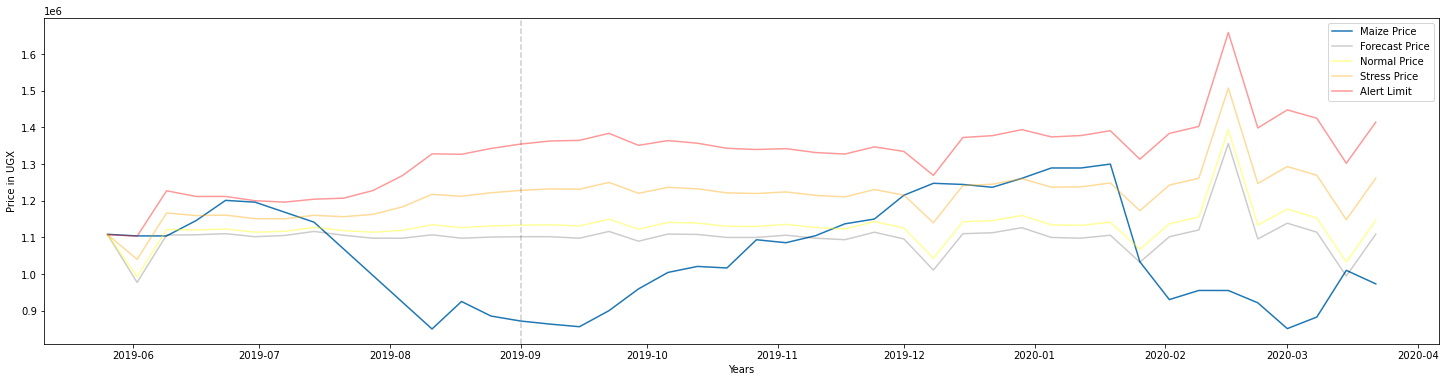

In [30]:
#plt.plot(weekly_lira[:stop_0], label = 'Maize Price')
plt.plot(errorstable['mean_price_7days'], label = 'Maize Price')
plt.plot(errorstable['forecast'], label = 'Forecast Price', color='k', alpha=0.2)
plt.plot(errorstable['normal_limit'], label = 'Normal Price', color='yellow', alpha=0.4)
plt.plot(errorstable['stress_limit'], label = 'Stress Price', color='orange', alpha=0.4)
plt.plot(errorstable['alert_limit'], label = 'Alert Limit', color='red', alpha=0.4)

for year in range(2019,2020):
    plt.axvline(pd.to_datetime(str(year) + '-09-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.legend(loc='best')
plt.show()

In [ ]:
build_bands_wfp_forecast(errorstable).values.tolist()

In [42]:
datetime.date(datetime.datetime.today().year, datetime.datetime.today().month, datetime.datetime.today().day).strftime('%Y-%m-%d')

'2020-05-22'

datetime.datetime(2020, 5, 22, 17, 14, 40, 57289)

##  Finding the best dummy variables

In [73]:
kampala_ws


,date_price,unit_scale,wholesale_observed_price
0,2016-01-01,mt,832163.0
1,2016-01-01,mt,890001.0
2,2016-01-04,mt,800002.0
3,2016-01-04,mt,756976.0
4,2016-01-05,mt,751150.0
...,...,...,...
1485,2020-03-13,mt,1030560.0
1486,2020-03-17,mt,904315.0
1487,2020-03-19,mt,1041890.0
1488,2020-03-25,mt,891605.0


In [74]:
def prepare_data_to_ALPS(dataframe):
    
    ''' 
    Removes duplicates in dates column. 
    Verify unique unit scale.
    Try to correct typos.

    
    Make a dataframe with the last Sunday before the dates of the input dataframe, and the saturday of the last week in within the dates.
    Then Merge both dataframes to have one with all the possible weeks within the dates of the original dataframe.
    Interpolate the missing values.
    Returns the metric and the dataframe with the values.
    '''
    
    cfd = dataframe.copy()    
   
    # Remove duplicates in dates column.
    
    drop_index = list(cfd[cfd.duplicated(['date_price'], keep='first')].index)
    
    cfd = cfd.drop(labels=drop_index, axis=0).reset_index(drop=True)

    # Consider the mode of unit scale as the one.
    
    mode = stats.mode(cfd.iloc[:,1])[0][0]
    
    discording_scale = list(cfd[cfd['unit_scale'] != mode].index)

    
    if discording_scale:
        
        cfd = cfd.drop(labels=discording_scale, axis=0).reset_index(drop=True)  
       
    # Drop outliers - the first round will face typos, the seconds truly outliers.
    
    z = np.abs(stats.zscore(cfd.iloc[:,-1], nan_policy='omit'))
    
    drop_index = list(np.where(z>4)[0])   
   
    cfd = cfd.drop(labels=drop_index, axis=0).reset_index(drop=True)
    
    # Second round.
    
    z = np.abs(stats.zscore(cfd.iloc[:,-1], nan_policy='omit'))
    
    drop_index = list(np.where(z>5)[0])
    
    cfd = cfd.drop(labels=drop_index, axis=0).reset_index(drop=True)
    

    # Turn the dataframe into a calendar.
    
    if datetime.date.weekday(cfd['date_price'].min()) == 6:
        start = datetime.date.weekday(cfd['date_price'].min())
    else:
        start = cfd['date_price'].min() - datetime.timedelta(days=datetime.date.weekday(cfd['date_price'].min()) + 1)
    if datetime.date.weekday(cfd['date_price'].max()) == 5:
        end = datetime.date.weekday(cfd['date_price'].min())
    else:
        end = cfd['date_price'].max() + datetime.timedelta(days=(5 - datetime.date.weekday(cfd['date_price'].max())))
        
    dummy = pd.DataFrame()
    dummy['date_price'] = pd.date_range(start=start, end=end)
    dummy = dummy.set_index('date_price')
    cfd = cfd.set_index('date_price')
    cfd = dummy.merge(cfd,how='outer',left_index=True, right_index=True)
    del dummy
 
    
    cfd['mean_price_7days'] = cfd.iloc[:,-1].rolling(window=7,min_periods=1).mean()
    
    cfd = cfd[cfd.index.dayofweek == 6]
    
    cfd = cfd[['mean_price_7days']].interpolate()
    
    cfd = cfd.dropna()

    return mode, cfd



In [77]:
metric, cfd = prepare_data_to_ALPS(kampala_ws)
cfd

,mean_price_7days
date_price,
2016-01-03,8.321630e+05
2016-01-10,7.684604e+05
2016-01-17,7.208322e+05
2016-01-24,6.282982e+05
2016-01-31,6.604810e+05
...,...
2020-02-23,9.214072e+05
2020-03-01,8.509670e+05
2020-03-08,8.824807e+05


In [107]:
# I'll considering 80% of data to train.
# Then build the bands starting on the first following date.

forecasted_prices = []

stop_0 = cfd.index[round(len(cfd) *.8)]
baseset = cfd.loc[:stop_0].copy()

for i in range(0,(len(cfd)- len(baseset))+1):
    
#     print(stop_0 + datetime.timedelta(weeks=i))
    
    # Baseline
    workset = cfd.loc[:stop_0 + datetime.timedelta(weeks=i)].copy()

    workset['t-1'] = workset['mean_price_7days'].shift(1)
    workset['t-2'] = workset['mean_price_7days'].shift(2)
    workset['t-3'] = workset['mean_price_7days'].shift(3)
    workset['t-4'] = workset['mean_price_7days'].shift(4)

    workset = workset.drop(labels=list(workset[workset['t-4'].isnull()].index), axis=0)

    # In what week are we?
    workset['week'] = workset.index.week

    # Build the dummy variables for each week. 
    workset = workset.join(pd.get_dummies(workset['week']))
    workset = workset.drop(labels=['week'], axis=1)




    features = workset.columns[1:]
    target = workset.columns[0]

    X = workset[features]
    y = workset[target]

    reg = LinearRegression()

    reg = reg.fit(X,y)

    previous_week_4 = cfd.loc[stop_0 + datetime.timedelta(weeks=4)]
    previous_week_3 = cfd.loc[stop_0 + datetime.timedelta(weeks=3)]
    previous_week_2 = cfd.loc[stop_0 + datetime.timedelta(weeks=4)]
    previous_week_1 = cfd.loc[stop_0 + datetime.timedelta(weeks=1)]

    next_week = cfd.loc[stop_0 + datetime.timedelta(weeks=1)]

    raw_next_week = [next_week.values[0],previous_week_1,previous_week_2,previous_week_3,previous_week_4] + [0 if i != next_week.name.week else 1 for i in range(52)]

    np.array(raw_next_week[1:]).reshape(1,-1)

    forecasted_prices.append(reg.predict(np.array(raw_next_week[1:]).reshape(1,-1))[0])

In [102]:
workset

,mean_price_7days,t-1,t-2,t-3,t-4,1,2,3,4,5,...,43,44,45,46,47,48,49,50,51,52
date_price,,,,,,,,,,,,,,,,,,,,,
2016-01-31,660481.0,628298.2,720832.2,768460.4,832163.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2016-02-07,708551.8,660481.0,628298.2,720832.2,768460.4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2016-02-14,717343.0,708551.8,660481.0,628298.2,720832.2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-02-21,749200.0,717343.0,708551.8,660481.0,628298.2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-02-28,742246.0,749200.0,717343.0,708551.8,660481.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-28,1225197.5,1149618.0,1112660.0,852050.4,698116.2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-05,1307120.0,1225197.5,1149618.0,1112660.0,852050.4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-12,1200482.0,1307120.0,1225197.5,1149618.0,1112660.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
def build_bands_wfp_forecast(dataframe):
    
    dataframe['residuals'] = dataframe['mean_price_7days'] - dataframe['forecast']
    dataframe['cum_residual_std'] = [np.std(dataframe.iloc[:i,2]) for i in range(1,len(dataframe)+1)]
    dataframe['ALPS'] = [None] + list(dataframe.iloc[1:,2]  / dataframe.iloc[1:,3])
    dataframe['Price Status'] = None

    for date in range(len(dataframe)):

        if dataframe.iloc[date,4] < 0.25:
            dataframe.iloc[date,5] = 'Normal'
        elif dataframe.iloc[date,4] < 1:
            dataframe.iloc[date,5] = 'Stress'
        elif dataframe.iloc[date,4] < 2:
            dataframe.iloc[date,5] = 'Alert'
        else:
            dataframe.iloc[date,5] = 'Crisis'
       
    dataframe['normal_limit'] = dataframe['forecast'] + 0.25 * dataframe['cum_residual_std']
    dataframe['stress_limit'] = dataframe['forecast'] + dataframe['cum_residual_std']
    dataframe['alert_limit'] = dataframe['forecast'] + 2 * dataframe['cum_residual_std']
    
       
    return dataframe


In [109]:
errorstable = cfd.loc[stop_0:]
errorstable['forecast'] = forecasted_prices
errorstable = build_bands_wfp_forecast(errorstable)
errorstable

C:\Users\jcm\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jcm\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jcm\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

,mean_price_7days,forecast,residuals,cum_residual_std,ALPS,Price Status,normal_limit,stress_limit,alert_limit
date_price,,,,,,,,,
2019-05-26,1.108252e+06,1.087961e+06,20291.311278,0.000000,NaN,Crisis,1.087961e+06,1.087961e+06,1.087961e+06
2019-06-02,1.103974e+06,1.087255e+06,16719.363051,1785.974113,9.361481,Crisis,1.087701e+06,1.089041e+06,1.090827e+06
2019-06-09,1.103928e+06,1.086489e+06,17439.490133,1542.374828,11.306908,Crisis,1.086874e+06,1.088031e+06,1.089573e+06
2019-06-16,1.145754e+06,1.086444e+06,59309.855047,17872.700036,3.318461,Crisis,1.090912e+06,1.104317e+06,1.122190e+06
2019-06-23,1.200932e+06,1.086064e+06,114868.558465,38088.448450,3.015837,Crisis,1.095586e+06,1.124152e+06,1.162241e+06
2019-06-30,1.196056e+06,1.084132e+06,111924.417339,42633.202281,2.625288,Crisis,1.094790e+06,1.126765e+06,1.169398e+06
2019-07-07,1.168748e+06,1.083954e+06,84794.422328,40671.592430,2.084856,Crisis,1.094121e+06,1.124625e+06,1.165297e+06
2019-07-14,1.141440e+06,1.083992e+06,57448.424442,38060.588940,1.509394,Alert,1.093507e+06,1.122052e+06,1.160113e+06
2019-07-21,1.068580e+06,1.084002e+06,-15422.371884,43066.241772,-0.358108,Normal,1.094769e+06,1.127069e+06,1.170135e+06


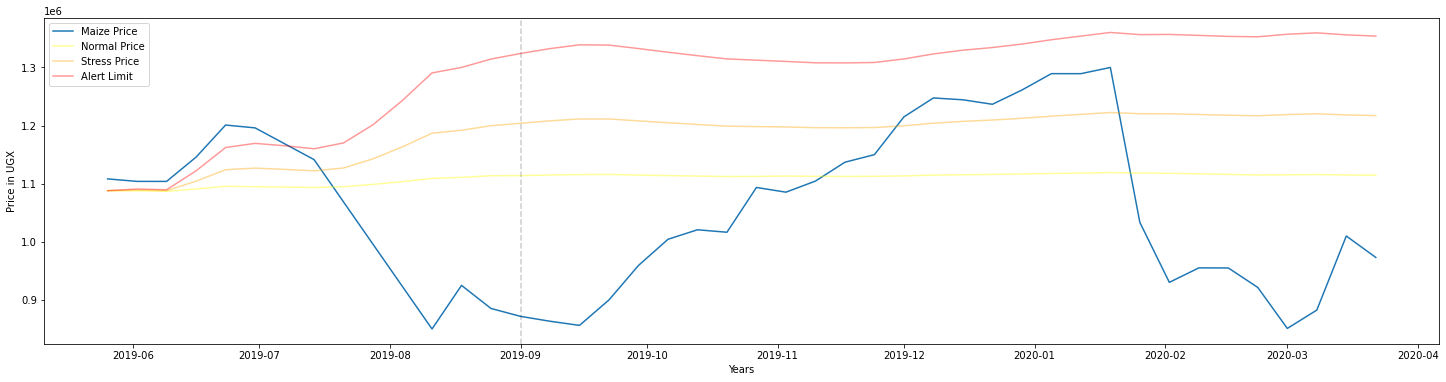

In [113]:
#plt.plot(weekly_lira[:stop_0], label = 'Maize Price')
plt.plot(errorstable['mean_price_7days'], label = 'Maize Price')
# plt.plot(errorstable['forecast'], label = 'Forecast Price', color='k', alpha=0.2)
plt.plot(errorstable['normal_limit'], label = 'Normal Price', color='yellow', alpha=0.4)
plt.plot(errorstable['stress_limit'], label = 'Stress Price', color='orange', alpha=0.4)
plt.plot(errorstable['alert_limit'], label = 'Alert Limit', color='red', alpha=0.4)

for year in range(2019,2020):
    plt.axvline(pd.to_datetime(str(year) + '-09-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.legend(loc='best')
plt.show()

### If we consider to work with max of the month, how could it be?

In [195]:
def prepare_data_to_ALPS_monthly(dataframe):
    
    ''' 
    Removes duplicates in dates column. 
    Verify unique unit scale.
    Try to correct typos.

    
    Make a dataframe with the last Sunday before the dates of the input dataframe, and the saturday of the last week in within the dates.
    Then Merge both dataframes to have one with all the possible weeks within the dates of the original dataframe.
    Interpolate the missing values.
    Returns the metric and the dataframe with the values.
    '''
    
    cfd = dataframe.copy()    
   
    # Remove duplicates in dates column.
    
    drop_index = list(cfd[cfd.duplicated(['date_price'], keep='first')].index)
    
    cfd = cfd.drop(labels=drop_index, axis=0).reset_index(drop=True)

    # Consider the mode of unit scale as the one.
    
    mode = stats.mode(cfd.iloc[:,1])[0][0]
    
    discording_scale = list(cfd[cfd['unit_scale'] != mode].index)

    
    if discording_scale:
        
        cfd = cfd.drop(labels=discording_scale, axis=0).reset_index(drop=True)  
       
    # Drop outliers - the first round will face typos, the seconds truly outliers.
    
    z = np.abs(stats.zscore(cfd.iloc[:,-1], nan_policy='omit'))
    
    drop_index = list(np.where(z>4)[0])   
   
    cfd = cfd.drop(labels=drop_index, axis=0).reset_index(drop=True)
    
    # Second round.
    
    z = np.abs(stats.zscore(cfd.iloc[:,-1], nan_policy='omit'))
    
    drop_index = list(np.where(z>5)[0])
    
    cfd = cfd.drop(labels=drop_index, axis=0).reset_index(drop=True)
    

    # Turn the dataframe into a calendar.
    
    if cfd['date_price'].min().day == 1:
        start = cfd['date_price'].min()
    else:
        start = cfd['date_price'].min() - datetime.timedelta(days=cfd['date_price'].min().day + 1)
    if cfd['date_price'].max().day >= 28:
        end = cfd['date_price'].max()
    else:
        end = cfd['date_price'].max() - datetime.timedelta(days=cfd['date_price'].max().day +1)
     
    dummy = pd.DataFrame()
    dummy['date_price'] = pd.date_range(start=start, end=end)
    dummy = dummy.set_index('date_price')
    cfd = cfd.set_index('date_price')
    cfd = dummy.merge(cfd,how='outer',left_index=True, right_index=True)
    del dummy
 
    
    cfd['max_price_30days'] = cfd.iloc[:,-1].rolling(window=30,min_periods=1).max()
    
    cfd = cfd[cfd.index.day == 1]
    
    cfd = cfd[['max_price_30days']].interpolate()
    
    cfd = cfd.dropna()

    return mode, cfd

In [196]:
# prepare_data_to_ALPS_monthly(kampala_ws.iloc[:,:])
metric, cfd = prepare_data_to_ALPS_monthly(kampala_ws)
cfd

,max_price_30days
date_price,
2016-01-01,832163.0
2016-02-01,800002.0
2016-03-01,799998.0
2016-04-01,820000.0
2016-05-01,854563.0
2016-06-01,950000.0
2016-07-01,970000.0
2016-08-01,956853.0
2016-09-01,840000.0


In [197]:
res = sm.tsa.arma_order_select_ic(cfd['max_price_30days'], ic='aic', trend='c')
res.aic_min_order

C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 0)

In [304]:
# I'll considering 80% of data to train.
# Then build the bands starting on the first following date.

forecasted_prices = []

stop_0 = cfd.index[round(len(cfd) *.8)]
baseset = cfd.loc[:stop_0].copy()

for i in range(0,(len(cfd)- len(baseset))):
    
#     print(stop_0 + datetime.timedelta(weeks=i))
    
    # Baseline
    workset = cfd.iloc[:len(cfd.loc[:stop_0])+ i,:].copy()
    
    # In what month are we?
    workset['month'] = workset.index.month

    # Build the dummy variables for each month. 
    workset = workset.join(pd.get_dummies(workset['month']))
    workset = workset.drop(labels=['month'], axis=1)

    features = workset.columns[1:]
    target = workset.columns[0]

    X = workset[features]
    y = workset[target]

    reg = LinearRegression()

    reg = reg.fit(X,y)

    next_month = cfd.loc[cfd.index[len(workset)]]

    raw_next_month = [next_month.values[0]] + [0 if i != next_month.name.month else 1 for i in range(12)]

    np.array(raw_next_month[1:]).reshape(1,-1)

    forecasted_prices.append(reg.predict(np.array(raw_next_month[1:]).reshape(1,-1))[0])

In [297]:
def build_bands_wfp_forecast(dataframe):
    
    dataframe['residuals'] = dataframe['max_price_30days'] - dataframe['forecast']
    dataframe['cum_residual_std'] = [np.std(dataframe.iloc[:i,2]) for i in range(1,len(dataframe)+1)]
    dataframe['ALPS'] = [None] + list(dataframe.iloc[1:,2]  / dataframe.iloc[1:,3])
    dataframe['Price Status'] = None

    for date in range(len(dataframe)):

        if dataframe.iloc[date,4] < 0.25:
            dataframe.iloc[date,5] = 'Normal'
        elif dataframe.iloc[date,4] < 1:
            dataframe.iloc[date,5] = 'Stress'
        elif dataframe.iloc[date,4] < 2:
            dataframe.iloc[date,5] = 'Alert'
        else:
            dataframe.iloc[date,5] = 'Crisis'
       
    dataframe['normal_limit'] = dataframe['forecast'] + 0.25 * dataframe['cum_residual_std']
    dataframe['stress_limit'] = dataframe['forecast'] + dataframe['cum_residual_std']
    dataframe['alert_limit'] = dataframe['forecast'] + 2 * dataframe['cum_residual_std']
    
       
    return dataframe

In [323]:
errorstable = cfd.iloc[len(cfd.loc[:stop_0]):,:]
errorstable['forecast'] = forecasted_prices
errorstable = build_bands_wfp_forecast(errorstable)
errorstable

C:\Users\jcm\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jcm\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jcm\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

,max_price_30days,forecast,residuals,cum_residual_std,ALPS,Price Status,normal_limit,stress_limit,alert_limit
date_price,,,,,,,,,
2019-06-01,1300000.0,1.140000e+06,160000.333333,0.000000,NaN,Crisis,1.140000e+06,1.140000e+06,1.140000e+06
2019-07-01,1250000.0,8.656187e+05,384381.333333,112190.500000,3.426149,Crisis,8.936663e+05,9.778092e+05,1.090000e+06
2019-08-01,1141440.0,8.245040e+05,316936.000000,94000.301194,3.371649,Crisis,8.480041e+05,9.185043e+05,1.012505e+06
2019-09-01,950000.0,8.635483e+05,86451.666667,119063.803846,0.726095,Stress,8.933143e+05,9.826121e+05,1.101676e+06
2019-10-01,980000.0,9.027797e+05,77220.333333,124188.285577,0.621800,Stress,9.338267e+05,1.026968e+06,1.151156e+06
2019-11-01,1100840.0,9.615857e+05,139254.333333,115985.273603,1.200621,Alert,9.905820e+05,1.077571e+06,1.193556e+06
2019-12-01,1230000.0,9.811144e+05,248885.590278,109083.034182,2.281616,Crisis,1.008385e+06,1.090197e+06,1.199280e+06
2020-01-01,1278750.0,8.765792e+05,402170.750000,121653.769776,3.305863,Crisis,9.069927e+05,9.982330e+05,1.119887e+06
2020-02-01,1308030.0,9.384253e+05,369604.750000,123151.146069,3.001229,Crisis,9.692130e+05,1.061576e+06,1.184728e+06


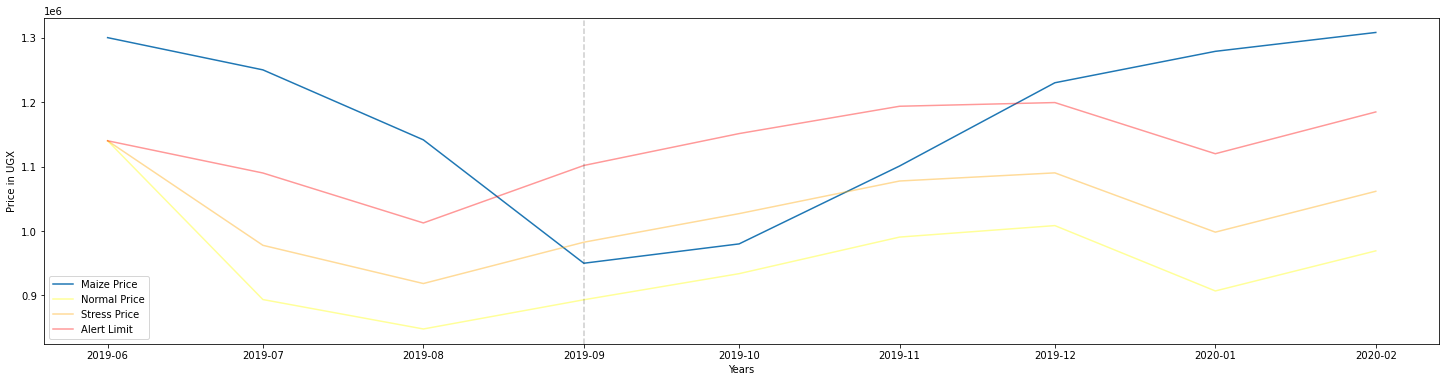

In [329]:
# plt.plot(cfd[stop_0:], label = 'Maize Price')
plt.plot(errorstable['max_price_30days'], label = 'Maize Price')
# plt.plot(errorstable['forecast'], label = 'Forecast Price', color='k', alpha=0.2)
plt.plot(errorstable['normal_limit'], label = 'Normal Price', color='yellow', alpha=0.4)
plt.plot(errorstable['stress_limit'], label = 'Stress Price', color='orange', alpha=0.4)
plt.plot(errorstable['alert_limit'], label = 'Alert Limit', color='red', alpha=0.4)

for year in range(2019,2020):
    plt.axvline(pd.to_datetime(str(year) + '-09-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.legend(loc='best')
plt.show()